In [1]:
# basic packages
import pandas as pd
import numpy as np

# visualization
import seaborn as sb
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# data scalers
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

# data imputation
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# model training
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# classifiers
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.linear_model import LogisticRegression # logistic regression
from sklearn.tree import DecisionTreeClassifier # decision Tree
from sklearn.neural_network import MLPClassifier # multi layer perceptron (simple neural net)
from sklearn.ensemble import RandomForestClassifier # random forest
from sklearn.ensemble import GradientBoostingClassifier # gbm
import xgboost as xgb # xgboost

# preprocessing and model output
from sklearn.preprocessing import LabelEncoder
from joblib import dump, load
from sklearn.metrics import confusion_matrix

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Import data and data cleaning

In [2]:
data = pd.read_csv('Final Dataset.csv')
data.head()

,Unnamed: 0,Unnamed: 0.1,Title,Technology Broad Category,Technology Mid-Type,Technology Sub-Type,Status,Rated Power (kW),Duration (hours),Latitude,...,Longitude_East,Longitude_West,Elevation,Elevation_North,Elevation_South,Elevation_East,Elevation_West,Max Temp,Min Temp,Average Temp
0,0,0,Ponale (Riva del Garda Ledro) Hydroelectric Po...,Pumped Hydro Storage,Open-loop Pumped Hydro Storage,Open-loop Pumped Hydro Storage,Operational,80000,0.0,45.888517,...,10.845,10.835,90.318260,94.701324,62.795341,74.825035,188.014160,16.9,-0.6,8.075000
1,1,1,Urdiceto Hydroelectric Power Station,Pumped Hydro Storage,Open-loop Pumped Hydro Storage,Open-loop Pumped Hydro Storage,Operational,7200,0.0,42.633421,...,0.225,0.215,1002.296509,1249.593384,1091.346802,1076.144287,1079.851440,17.7,7.6,12.233333
2,2,2,Rocky River Pumped Storage Plant,Pumped Hydro Storage,Open-loop Pumped Hydro Storage,Open-loop Pumped Hydro Storage,Operational,29000,0.0,41.582580,...,-73.425,-73.435,66.019066,68.805016,129.584091,61.000000,67.746742,20.7,-6.0,7.833333
3,3,3,Etzelwerk Pumped Hydro Storage Power Station,Pumped Hydro Storage,Open-loop Pumped Hydro Storage,Open-loop Pumped Hydro Storage,Operational,135000,0.0,47.136963,...,8.785,8.775,888.960022,888.960022,888.960022,888.960022,889.000000,16.9,-0.6,8.075000
4,4,4,Skhodnenskaya Hydro Plant,Pumped Hydro Storage,Open-loop Pumped Hydro Storage,Open-loop Pumped Hydro Storage,Operational,30000,0.0,55.850657,...,37.445,37.435,173.639954,175.949539,171.961624,174.227707,176.101135,17.0,-9.7,4.266667


# Fill zero duration and rated power
data['Duration (hours)'].loc[data['Duration (hours)']==0] = np.nan
data['Duration (hours)']= data.groupby("Technology Sub-Type")['Duration (hours)'].transform(lambda x: x.fillna(x.median()))

data['Rated Power (kW)'].loc[data['Rated Power (kW)']==0] = np.nan
data['Rated Power (kW)']= data.groupby("Technology Sub-Type")['Rated Power (kW)'].transform(lambda x: x.fillna(x.median()))
data.head()

In [3]:
# Get elevation difference
data['Elevation_North'] = abs(data['Elevation_North'] - data['Elevation'])
data['Elevation_South'] = abs(data['Elevation_South'] - data['Elevation'])
data['Elevation_East'] = abs(data['Elevation_East'] - data['Elevation'])
data['Elevation_West'] = abs(data['Elevation_West'] - data['Elevation'])
data['Elevation Difference'] = data[['Elevation_North','Elevation_South','Elevation_East','Elevation_West']].max(axis=1)

In [4]:
# Select columns to use for features X and targert Y
columns = ['Technology Broad Category','Technology Mid-Type','Technology Sub-Type','Status','Rated Power (kW)','Duration (hours)','Latitude','Longitude','Elevation','Elevation Difference','Max Temp','Min Temp','Average Temp']
data = data[columns]
data.head()

,Technology Broad Category,Technology Mid-Type,Technology Sub-Type,Status,Rated Power (kW),Duration (hours),Latitude,Longitude,Elevation,Elevation Difference,Max Temp,Min Temp,Average Temp
0,Pumped Hydro Storage,Open-loop Pumped Hydro Storage,Open-loop Pumped Hydro Storage,Operational,80000,0.0,45.888517,10.84,90.318260,97.695900,16.9,-0.6,8.075000
1,Pumped Hydro Storage,Open-loop Pumped Hydro Storage,Open-loop Pumped Hydro Storage,Operational,7200,0.0,42.633421,0.22,1002.296509,247.296875,17.7,7.6,12.233333
2,Pumped Hydro Storage,Open-loop Pumped Hydro Storage,Open-loop Pumped Hydro Storage,Operational,29000,0.0,41.582580,-73.43,66.019066,63.565025,20.7,-6.0,7.833333
3,Pumped Hydro Storage,Open-loop Pumped Hydro Storage,Open-loop Pumped Hydro Storage,Operational,135000,0.0,47.136963,8.78,888.960022,0.039978,16.9,-0.6,8.075000
4,Pumped Hydro Storage,Open-loop Pumped Hydro Storage,Open-loop Pumped Hydro Storage,Operational,30000,0.0,55.850657,37.44,173.639954,2.461182,17.0,-9.7,4.266667


In [5]:
# Remove missing value
col = np.where(pd.isnull(data))[1]
for i in range(max(col)+1):
    if (col==i).sum() > 0:
        print('number of missing values in ' + str(data.columns[i]) + ': ' + str((col==i).sum()))
print('total missing data :' + str(len(col)))
data = data.dropna()
print('number of datapoints after removing null values :' + str(len(data)))

number of missing values in Status: 1
total missing data :1
number of datapoints after removing null values :1692


In [6]:
# Remove decomissioned project
statuses = ['Operational','Offline/Under Repair','Under Construction']
data = data.loc[data['Status'].isin(statuses)]
print('number of datapoints after removing decomissioned and not building :' + str(len(data)))

number of datapoints after removing decomissioned and not building :1381


In [7]:
# Convert to datetime
def sec_to_day(y):
    h=int(y//3600%24)
    d=int(y//86400)
    m=int((y%3600)//60)
    s=round(y%60,2)
    return [d,h,m,s]
data['Day']=data['Duration (hours)'].map(lambda x: int((x*3600)//86400))
data['Hour']=data['Duration (hours)'].map(lambda x: int((x*3600)//3600%24))
data['Minute']=data['Duration (hours)'].map(lambda x: int(((x*3600)%3600)//60))
data['Second']=data['Duration (hours)'].map(lambda x: round((x*3600)%60,2))
data.head()   

,Technology Broad Category,Technology Mid-Type,Technology Sub-Type,Status,Rated Power (kW),Duration (hours),Latitude,Longitude,Elevation,Elevation Difference,Max Temp,Min Temp,Average Temp,Day,Hour,Minute,Second
0,Pumped Hydro Storage,Open-loop Pumped Hydro Storage,Open-loop Pumped Hydro Storage,Operational,80000,0.0,45.888517,10.84,90.318260,97.695900,16.9,-0.6,8.075000,0,0,0,0.0
1,Pumped Hydro Storage,Open-loop Pumped Hydro Storage,Open-loop Pumped Hydro Storage,Operational,7200,0.0,42.633421,0.22,1002.296509,247.296875,17.7,7.6,12.233333,0,0,0,0.0
2,Pumped Hydro Storage,Open-loop Pumped Hydro Storage,Open-loop Pumped Hydro Storage,Operational,29000,0.0,41.582580,-73.43,66.019066,63.565025,20.7,-6.0,7.833333,0,0,0,0.0
3,Pumped Hydro Storage,Open-loop Pumped Hydro Storage,Open-loop Pumped Hydro Storage,Operational,135000,0.0,47.136963,8.78,888.960022,0.039978,16.9,-0.6,8.075000,0,0,0,0.0
4,Pumped Hydro Storage,Open-loop Pumped Hydro Storage,Open-loop Pumped Hydro Storage,Operational,30000,0.0,55.850657,37.44,173.639954,2.461182,17.0,-9.7,4.266667,0,0,0,0.0


In [8]:
# Examine Categories
data.groupby('Technology Broad Category').count()['Technology Mid-Type']

Technology Broad Category
Compressed Air Energy Storage      2
Electro-chemical                 748
Electro-mechanical                55
Hydrogen Storage                   9
Lead-Carbon                        2
Liquid Air Energy Storage          1
Lithium Ion Battery               27
Pumped Hydro Storage             328
Thermal Storage                  209
Name: Technology Mid-Type, dtype: int64

In [9]:
data.groupby('Technology Mid-Type').count()['Technology Broad Category']

Technology Mid-Type
Advanced Lead-acid Battery             1
Chilled Water Thermal Storage         25
Closed-loop Pumped Hydro Storage       3
Compressed Air Energy Storage         13
Concrete Thermal Storage               1
Electrical-mechanical                  2
Electro-chemical                      86
Electro-chemical Capacitor            26
Electrochemical                        1
Flow Battery                          63
Flywheel                              41
Heat Thermal Storage                  19
Hydrogen Storage                       9
Ice Thermal Storage                  124
Lead-Carbon                            2
Lead-acid Battery                     75
Liquid Air Energy Storage              2
Lithium Ion Titanate Battery           1
Lithium Iron Phosphate Battery         3
Lithium Polymer Battery               28
Lithium-ion Battery                  413
Molten Salt Thermal Storage           34
Nickel based Battery                   6
Open-loop Pumped Hydro Storage       

## Grouping of Categories
The category grouping shall be done according to:
- ESS with similar properties such as different types of flow battery can be combined into a single category
- Each category should have sufficient number of datapoints

Grouping
- 'Technology Broad Category' grouping for pumped hydro and Electro-mechanical is maintained
- For Electro-chemical, there are large number of datapoints, and comprises of different types of technologies, hence 'Technology Mid-Type' will be used to further breakdown into more groups.
    - Lead based batteries (75+)
    - Lithium based batteries (413+)
    - Sodium based batteries (63+)
    - Flow batteries (63)
    - Other batteries that do not fall into those categories
- For Thermal storage, there are heat thermal and cold thermal storage

In [10]:
data['Category'] = data['Technology Broad Category']

#1. Lithium Battery
data['Category'].loc[data['Technology Mid-Type'].str.contains('Lithium')] = 'Lithium Battery'
#2. Lead Battery
data['Category'].loc[data['Technology Mid-Type'].str.contains('Lead')] = 'Lead Battery'
#3. Sodium Battery
data['Category'].loc[data['Technology Mid-Type'].str.contains('Sodium')] = 'Sodium Battery'
#4. Flow Battery
data['Category'].loc[data['Technology Mid-Type'].str.contains('Flow')] = 'Flow Battery'

#5. Cold thermal storage
data['Category'].loc[data['Technology Mid-Type'].str.contains('Chilled|Ice')] = 'Cold Thermal'
#6. Hot thermal storage
data['Category'].loc[data['Technology Mid-Type'].str.contains('Heat|Concrete|Molten')] = 'Hot Thermal'


In [11]:
data.groupby('Category').count()['Status']

Category
Cold Thermal                     150
Compressed Air Energy Storage      2
Electro-chemical                 119
Electro-mechanical                55
Flow Battery                      67
Hot Thermal                       54
Hydrogen Storage                   9
Lead Battery                      80
Liquid Air Energy Storage          1
Lithium Battery                  445
Pumped Hydro Storage             328
Sodium Battery                    67
Thermal Storage                    4
Name: Status, dtype: int64

In [12]:
# Consolidation of remaining small categories into larger categories
data['Category'].loc[data['Category'] == 'Compressed Air Energy Storage'] = 'Electro-mechanical'
data['Category'].loc[data['Category'] == 'Liquid Air Energy Storage'] = 'Electro-mechanical'
# Drop remaining thermal storage - unclear if cold or hot thermal
data = data.loc[data['Category'] != 'Thermal Storage']
# Drop Hydrogen Storage - dataset too small
data = data.loc[data['Category'] != 'Hydrogen Storage']
data.groupby('Category').count()['Status']

Category
Cold Thermal            150
Electro-chemical        119
Electro-mechanical       58
Flow Battery             67
Hot Thermal              54
Lead Battery             80
Lithium Battery         445
Pumped Hydro Storage    328
Sodium Battery           67
Name: Status, dtype: int64

## Exploratory Data Analysis & Data Processing

In [13]:
data.describe()

,Rated Power (kW),Duration (hours),Latitude,Longitude,Elevation,Elevation Difference,Max Temp,Min Temp,Average Temp,Day,Hour,Minute,Second
count,1.368000e+03,1368.000000,1368.000000,1368.000000,1368.000000,1368.000000,1368.000000,1368.000000,1368.000000,1368.000000,1368.000000,1368.000000,1368.000000
mean,1.275541e+05,14.426835,33.918213,-5.372465,224.920938,39.032829,21.018275,3.414985,12.166265,0.491959,2.478801,8.411550,2.964912
std,3.342279e+05,388.047966,19.538581,86.645725,863.361092,61.652829,4.756232,9.514957,6.094505,16.161808,3.311590,14.948664,10.204289
min,0.000000e+00,0.000000,-77.524740,-170.279946,-5464.533203,0.000000,-8.500000,-34.200000,-24.125000,0.000000,0.000000,0.000000,0.000000
25%,6.850000e+01,0.000000,33.101203,-82.545000,26.754828,5.297775,17.700000,-0.600000,8.100000,0.000000,0.000000,0.000000,0.000000
50%,1.000000e+03,1.330000,38.000000,0.000000,161.943100,13.361488,20.700000,2.900000,12.033333,0.000000,1.000000,0.000000,0.000000
75%,3.612500e+04,4.000000,43.583110,21.452500,442.101875,41.624542,24.400000,8.800000,15.066667,0.000000,4.000000,15.000000,0.000000
max,3.003000e+06,14310.330000,67.038639,174.170000,4280.655762,478.546387,35.700000,27.100000,28.925000,596.000000,23.000000,58.000000,48.000000


array([[<AxesSubplot:title={'center':'Rated Power (kW)'}>,
        <AxesSubplot:title={'center':'Duration (hours)'}>,
        <AxesSubplot:title={'center':'Latitude'}>,
        <AxesSubplot:title={'center':'Longitude'}>],
       [<AxesSubplot:title={'center':'Elevation'}>,
        <AxesSubplot:title={'center':'Elevation Difference'}>,
        <AxesSubplot:title={'center':'Max Temp'}>,
        <AxesSubplot:title={'center':'Min Temp'}>],
       [<AxesSubplot:title={'center':'Average Temp'}>,
        <AxesSubplot:title={'center':'Day'}>,
        <AxesSubplot:title={'center':'Hour'}>,
        <AxesSubplot:title={'center':'Minute'}>],
       [<AxesSubplot:title={'center':'Second'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

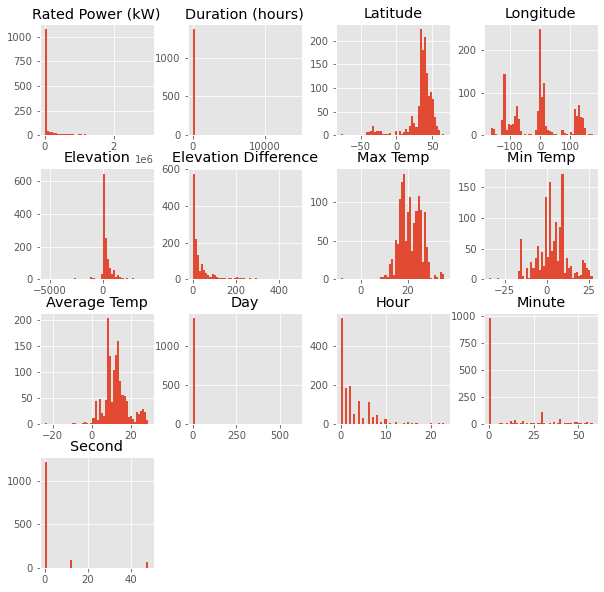

In [14]:
matplotlib.style.use('ggplot')
data.hist(bins=50, figsize=(10,10))

array([[<AxesSubplot:title={'center':'Log Scaler'}>,
        <AxesSubplot:title={'center':'Normalizer'}>],
       [<AxesSubplot:title={'center':'MinMaxScaler'}>,
        <AxesSubplot:title={'center':'Robust Scaler'}>]], dtype=object)

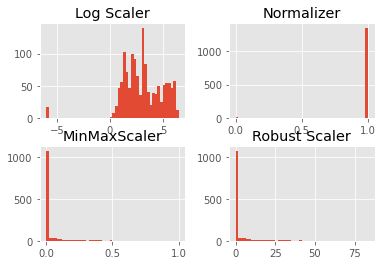

In [15]:
# Visualize for Rated Power
temp = pd.DataFrame()
temp['Log Scaler'] = np.log10(data['Rated Power (kW)']+0.000001)
temp['Normalizer'] = Normalizer().fit_transform(data['Rated Power (kW)'].values.reshape(-1,1))
temp['MinMaxScaler'] = MinMaxScaler().fit_transform(data['Rated Power (kW)'].values.reshape(-1,1))
temp['Robust Scaler'] = RobustScaler().fit_transform(data['Rated Power (kW)'].values.reshape(-1,1))
temp.hist(bins=50)

array([[<AxesSubplot:title={'center':'Log Scaler'}>,
        <AxesSubplot:title={'center':'Normalizer'}>],
       [<AxesSubplot:title={'center':'Robust Scaler'}>,
        <AxesSubplot:title={'center':'MinMaxScaler'}>]], dtype=object)

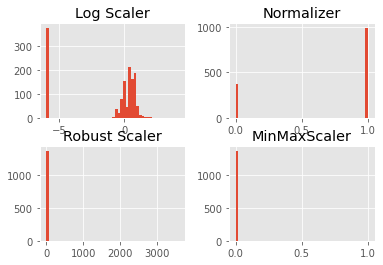

In [16]:
temp = pd.DataFrame()
temp['Log Scaler'] = np.log10(data['Duration (hours)']+0.000001)
temp['Normalizer'] = Normalizer().fit_transform(data['Duration (hours)'].values.reshape(-1,1))
temp['Robust Scaler'] = RobustScaler().fit_transform(data['Duration (hours)'].values.reshape(-1,1))
temp['MinMaxScaler'] = MinMaxScaler().fit_transform(data['Duration (hours)'].values.reshape(-1,1))
temp.hist(bins=50)

array([[<AxesSubplot:title={'center':'Log Scaler'}>,
        <AxesSubplot:title={'center':'Normalizer'}>],
       [<AxesSubplot:title={'center':'Robust Scaler'}>,
        <AxesSubplot:title={'center':'MinMaxScaler'}>]], dtype=object)

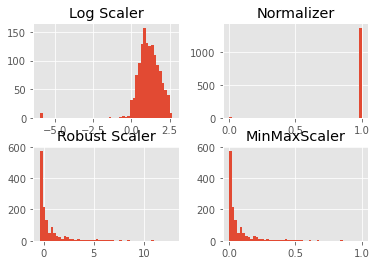

In [17]:
temp = pd.DataFrame()
temp['Log Scaler'] = np.log10(data['Elevation Difference']+0.000001)
temp['Normalizer'] = Normalizer().fit_transform(data['Elevation Difference'].values.reshape(-1,1))
temp['Robust Scaler'] = RobustScaler().fit_transform(data['Elevation Difference'].values.reshape(-1,1))
temp['MinMaxScaler'] = MinMaxScaler().fit_transform(data['Elevation Difference'].values.reshape(-1,1))
temp.hist(bins=50)

In [18]:
encoder = LabelEncoder()
tech_cat = data['Category']
tech_cat_encoded = encoder.fit_transform(tech_cat)
print(encoder.classes_)
data['Category Encoded'] = tech_cat_encoded

['Cold Thermal' 'Electro-chemical' 'Electro-mechanical' 'Flow Battery'
 'Hot Thermal' 'Lead Battery' 'Lithium Battery' 'Pumped Hydro Storage'
 'Sodium Battery']


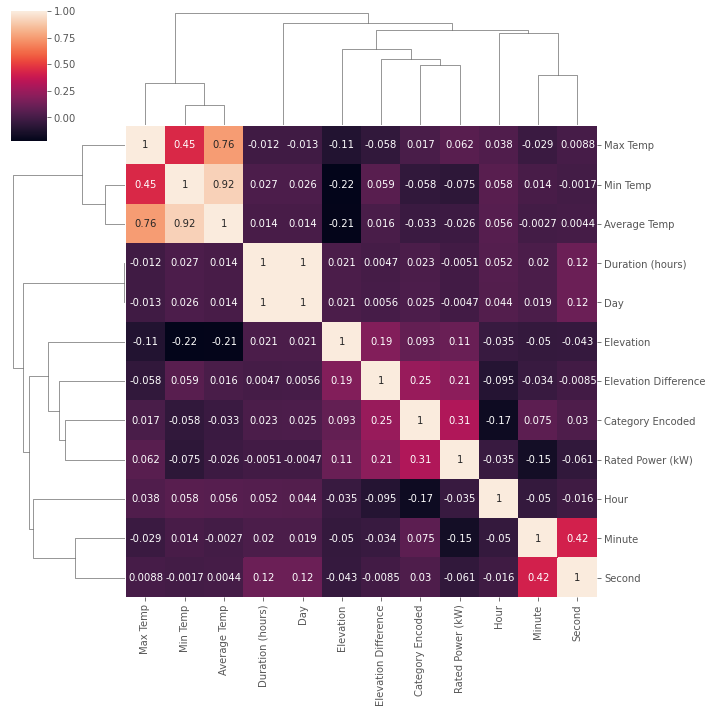

In [19]:
# Overall correlation
features = ['Category Encoded','Elevation','Elevation Difference', 'Rated Power (kW)', 'Duration (hours)','Min Temp','Max Temp','Average Temp','Day','Hour','Minute','Second'] 
sb.clustermap(data[features].corr(), annot=True)
plt.savefig('Corrrelation heatmap.svg',bbox_inches='tight')

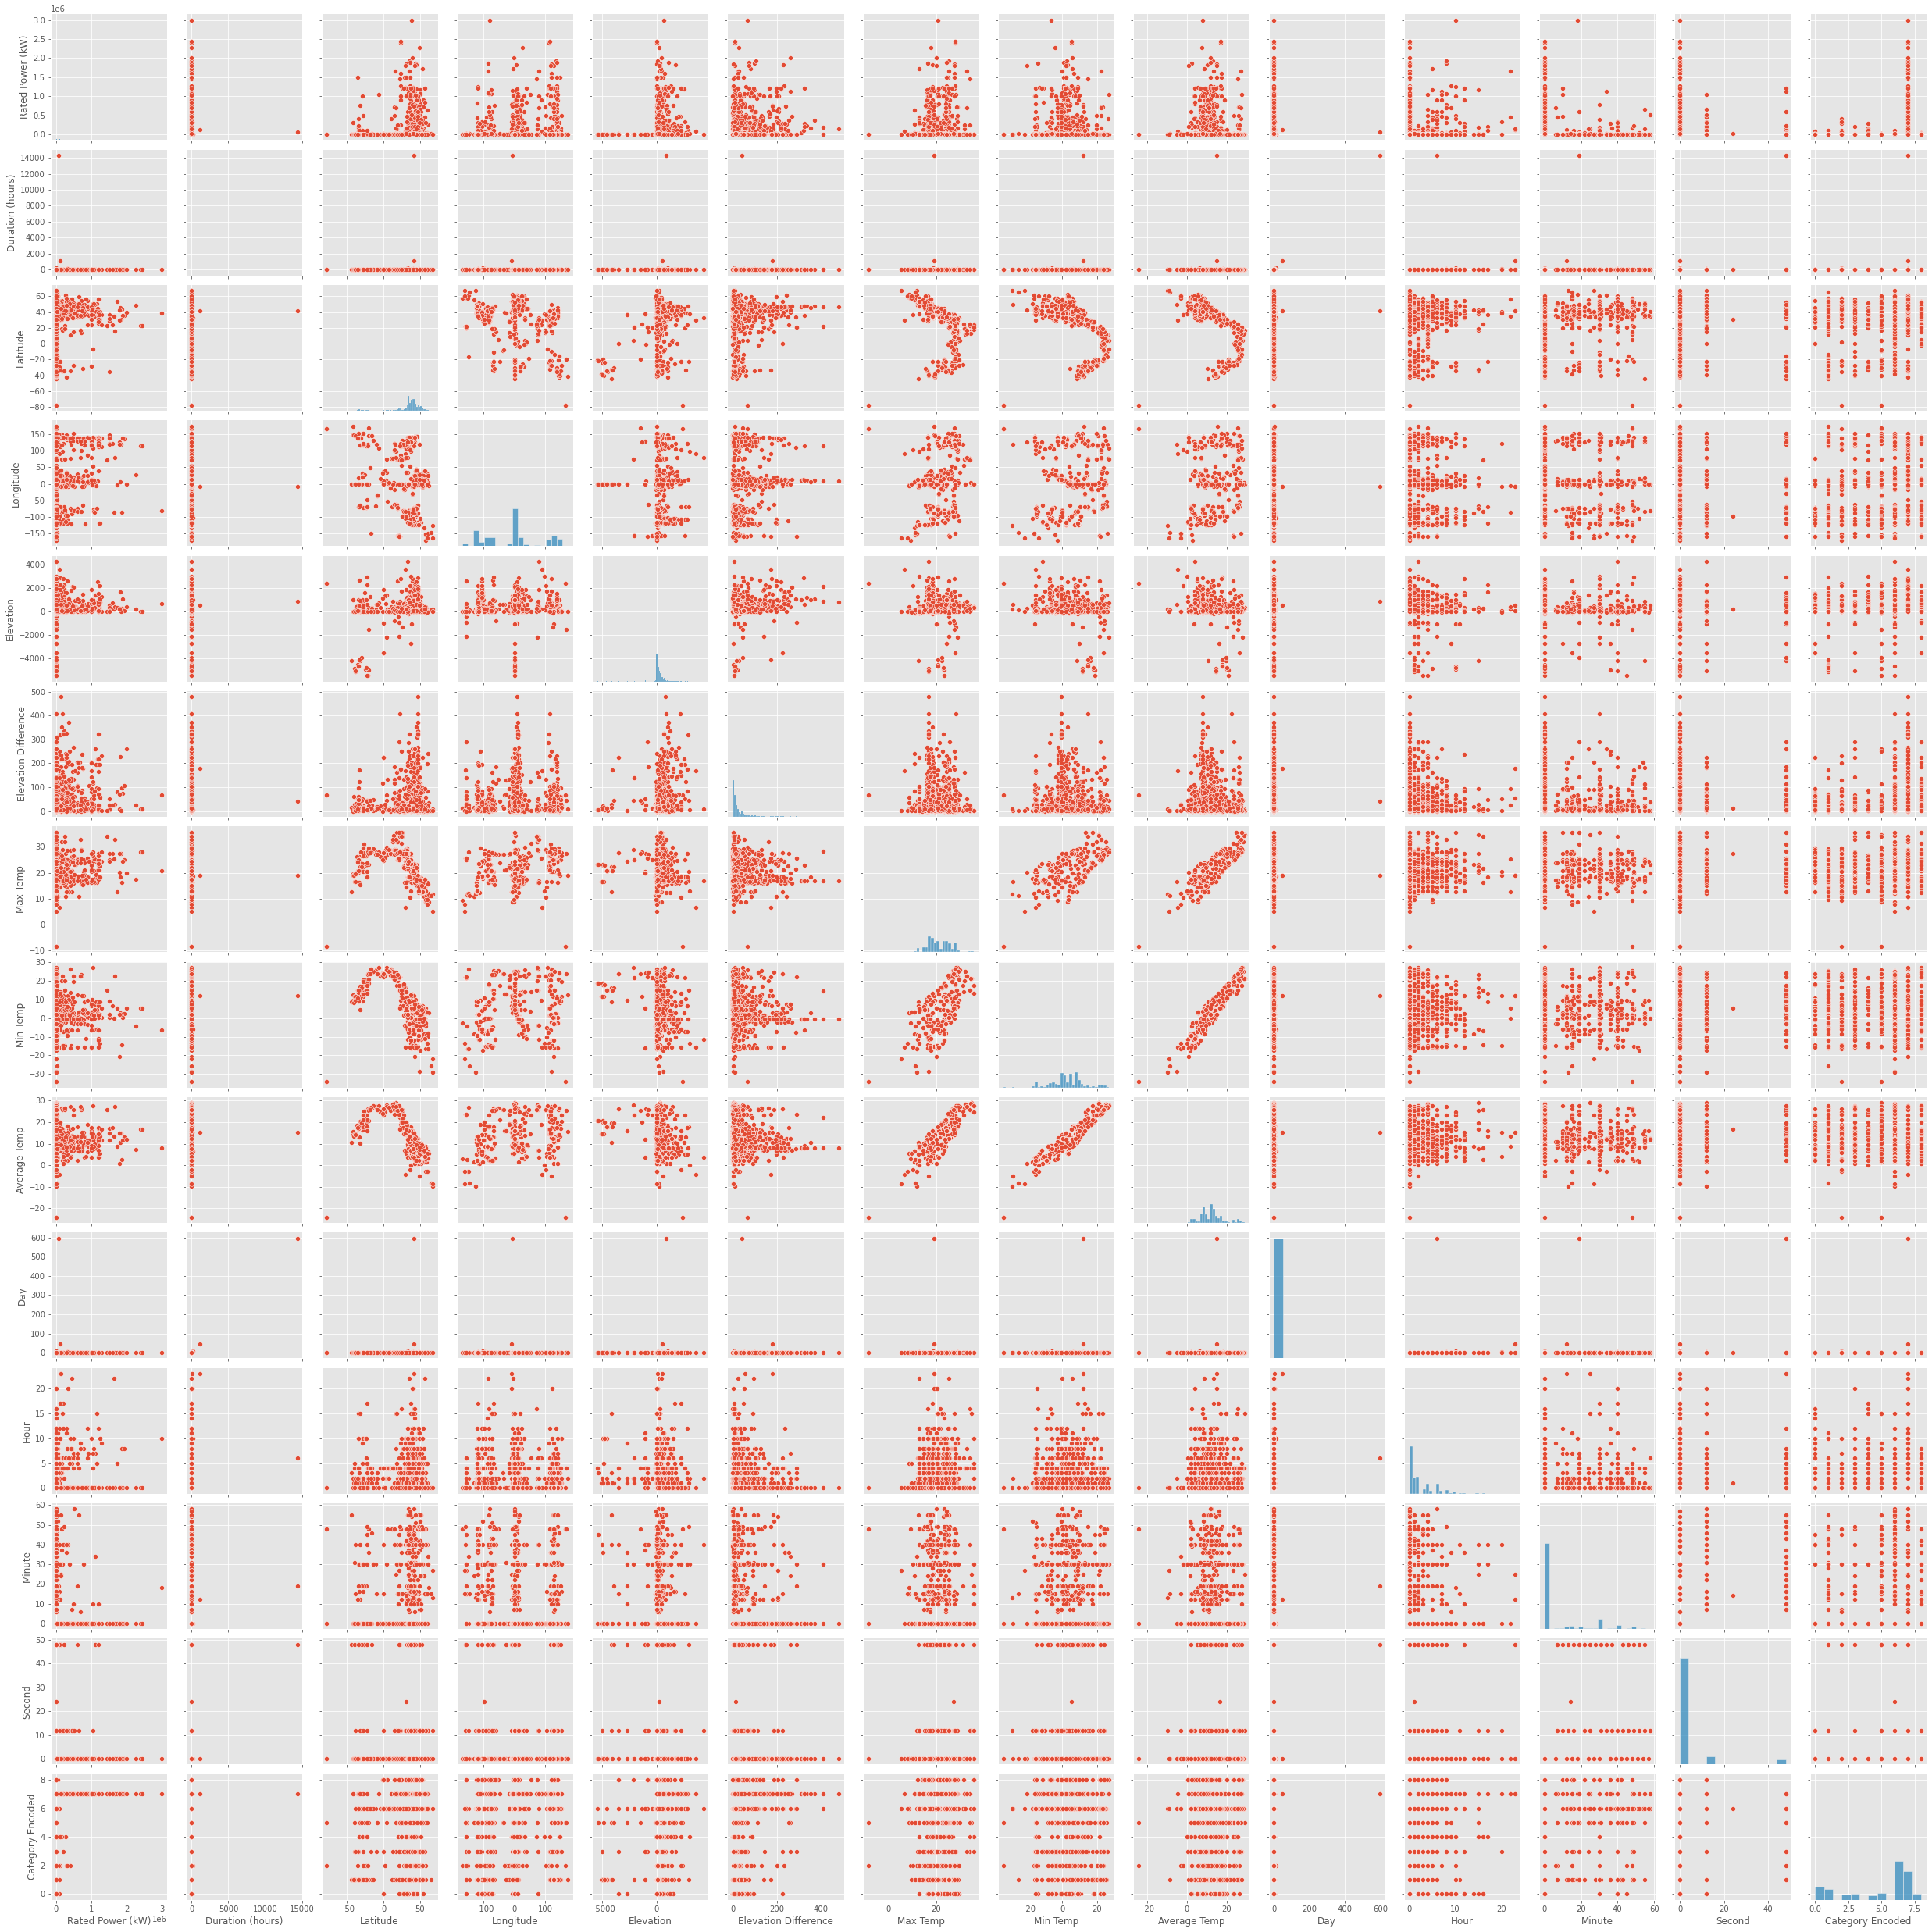

In [20]:
sb.pairplot(data)

In [21]:
# make a copy of the dataframe to apply transformations
data2 = data.copy()

In [22]:
# Applying log scaler
data2['Rated Power (kW)'] = np.log10(data2['Rated Power (kW)']+0.000001)
data2['Duration (hours)'] = np.log10(data2['Duration (hours)']+0.000001)
data2['Elevation Difference'] = np.log10(data2['Elevation Difference']+0.000001)

In [23]:
data2.columns

Index(['Technology Broad Category', 'Technology Mid-Type',
       'Technology Sub-Type', 'Status', 'Rated Power (kW)', 'Duration (hours)',
       'Latitude', 'Longitude', 'Elevation', 'Elevation Difference',
       'Max Temp', 'Min Temp', 'Average Temp', 'Day', 'Hour', 'Minute',
       'Second', 'Category', 'Category Encoded'],
      dtype='object')

In [24]:
# remove the following columns
to_drop = ['Technology Broad Category','Technology Mid-Type','Technology Sub-Type','Status','Longitude','Latitude','Category']
data2 = data2.drop(to_drop, axis=1)
data2.head()

,Rated Power (kW),Duration (hours),Elevation,Elevation Difference,Max Temp,Min Temp,Average Temp,Day,Hour,Minute,Second,Category Encoded
0,4.903090,-6.0,90.318260,1.989876,16.9,-0.6,8.075000,0,0,0,0.0,7
1,3.857332,-6.0,1002.296509,2.393219,17.7,7.6,12.233333,0,0,0,0.0,7
2,4.462398,-6.0,66.019066,1.803218,20.7,-6.0,7.833333,0,0,0,0.0,7
3,5.130334,-6.0,888.960022,-1.398168,16.9,-0.6,8.075000,0,0,0,0.0,7
4,4.477121,-6.0,173.639954,0.391144,17.0,-9.7,4.266667,0,0,0,0.0,7


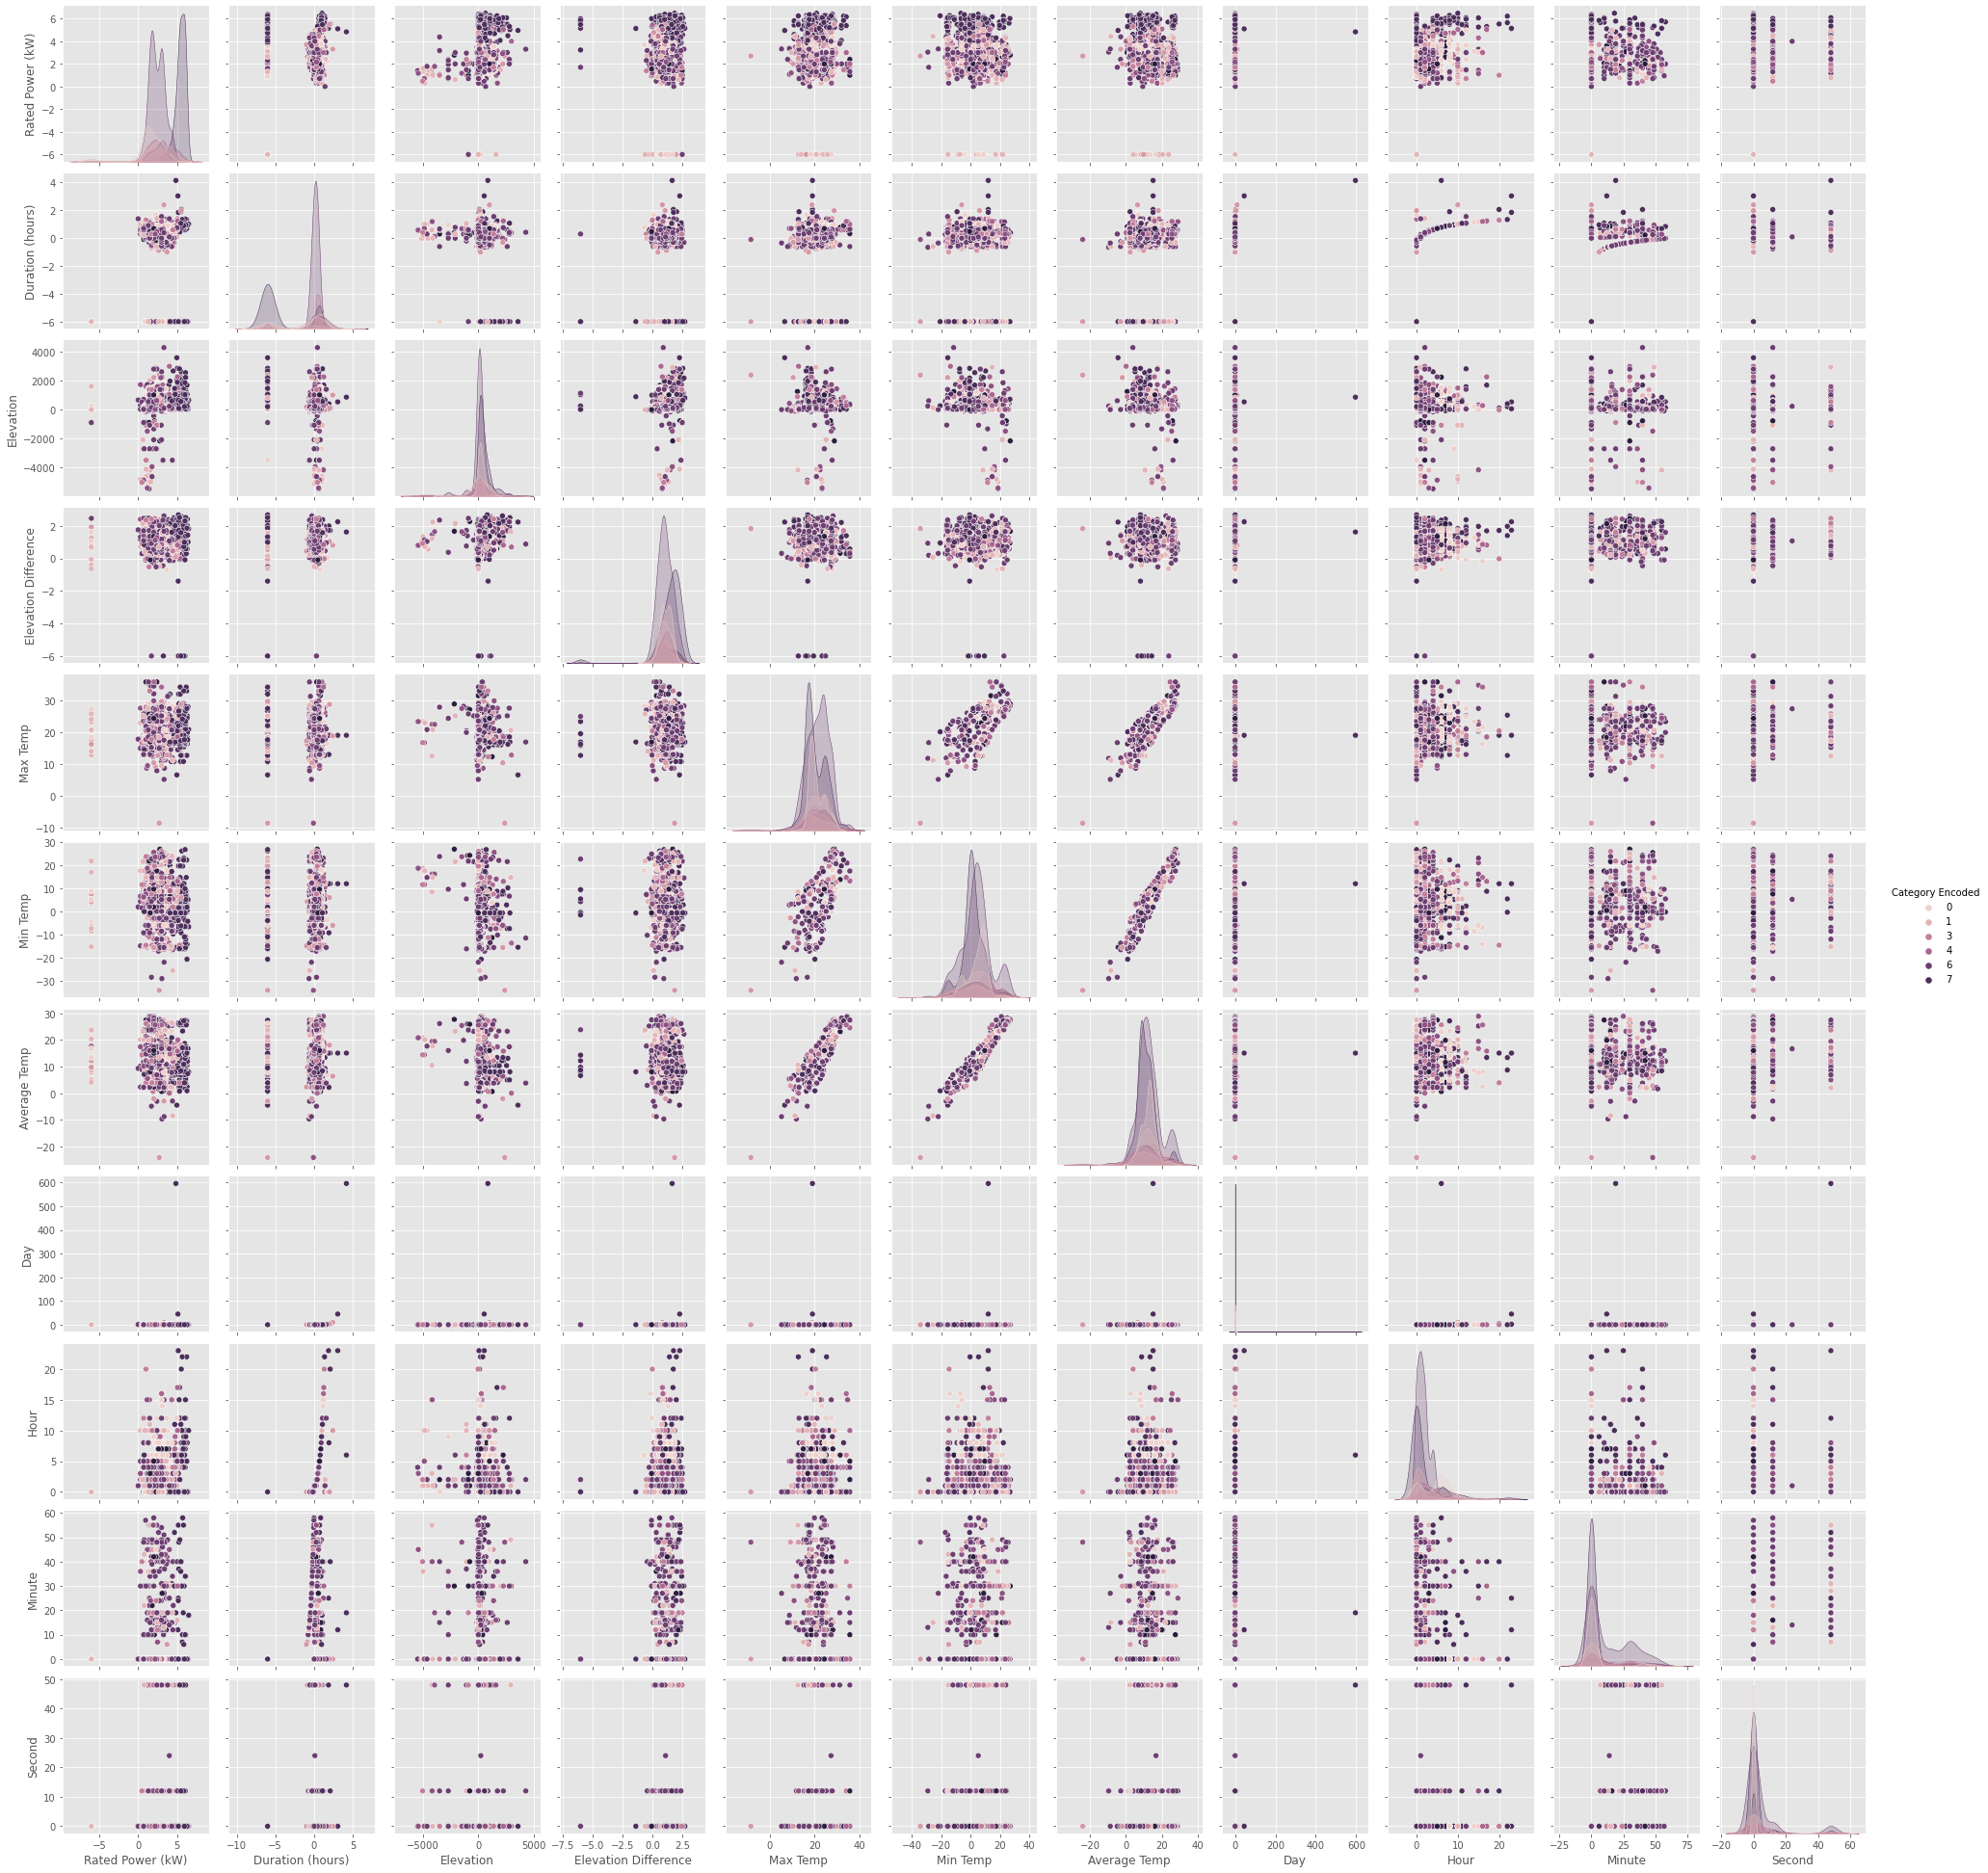

In [25]:
sb.pairplot(data2,hue='Category Encoded')

In [26]:
data2.groupby("Category Encoded").describe().unstack()

                         Category Encoded
Rated Power (kW)  count  0                   150.0
                         1                   119.0
                         2                    58.0
                         3                    67.0
                         4                    54.0
                                             ...  
Second            max    4                     0.0
                         5                    48.0
                         6                    48.0
                         7                    48.0
                         8                    12.0
Length: 792, dtype: float64

In [27]:
tech_cat_map=dict(zip(tech_cat_encoded,tech_cat))
print(tech_cat_map)

{7: 'Pumped Hydro Storage', 2: 'Electro-mechanical', 0: 'Cold Thermal', 5: 'Lead Battery', 3: 'Flow Battery', 8: 'Sodium Battery', 1: 'Electro-chemical', 4: 'Hot Thermal', 6: 'Lithium Battery'}


## Model Training

In [28]:
# control if log scaling is performed on Rated Power, Duration and Elevation Difference
SCALED = False

if SCALED:
    x = data2[['Rated Power (kW)','Duration (hours)','Elevation Difference', 'Max Temp', 'Min Temp', 'Average Temp']]
else:
    x = data.copy().drop(to_drop, axis=1)[['Rated Power (kW)','Duration (hours)','Elevation Difference', 'Max Temp', 'Min Temp', 'Average Temp']]

In [29]:
# data split
# x_train_final: to train the final model - 75% of data
# x_test_final: to test the performance of the final model - 25% of data
# x_train: to train different model for selecting model type - 60% of data
# x_val: to evaluate the different model types - 15% of data
if SCALED:
    y = data2['Category Encoded']
else:
    y = data['Category Encoded']
x_train_final, x_test_final, y_train_final, y_test_final = train_test_split(x, y, test_size = 0.25, random_state=0)
x_train, x_val, y_train, y_val = train_test_split(x_train_final, y_train_final, test_size = 0.2, random_state=0)

In [30]:
print(y_train_final.value_counts().sort_index())
print(y_train_final.value_counts().sum())

0    109
1     89
2     51
3     47
4     37
5     60
6    335
7    246
8     52
Name: Category Encoded, dtype: int64
1026


In [31]:
x_train_final.describe()

,Rated Power (kW),Duration (hours),Elevation Difference,Max Temp,Min Temp,Average Temp
count,1.026000e+03,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000
mean,1.248000e+05,4.434201,39.254294,21.037817,3.383431,12.157878
std,3.329646e+05,35.859850,62.979573,4.798046,9.785739,6.284700
min,0.000000e+00,0.000000,0.000000,-8.500000,-34.200000,-24.125000
25%,8.000000e+01,0.000000,5.233734,17.700000,-0.900000,8.100000
50%,1.000000e+03,1.500000,13.345535,20.700000,2.900000,11.841667
75%,3.350000e+04,4.000000,41.218628,24.400000,8.800000,15.066667
max,3.003000e+06,1103.200000,478.546387,35.700000,27.100000,28.766667


In [ ]:
impute = False # data inputation for value where 0
if impute:
    #imputer = SimpleImputer(missing_values=0, strategy='median')
    if SCALED:
        imputer = IterativeImputer(missing_values=-6.0)
    else:
        imputer = IterativeImputer(missing_values=0)
    imputer.fit(x_train)
    x_train = imputer.transform(x_train)
    x_val = imputer.transform(x_val)

K-Nearest Neighbors
              precision    recall  f1-score   support

           0       0.30      0.36      0.33        22
           1       0.32      0.38      0.34        16
           2       0.25      0.11      0.15         9
           3       0.00      0.00      0.00         8
           4       0.67      0.50      0.57         8
           5       0.25      0.18      0.21        11
           6       0.54      0.67      0.60        76
           7       0.95      0.84      0.89        44
           8       0.40      0.17      0.24        12

    accuracy                           0.54       206
   macro avg       0.41      0.36      0.37       206
weighted avg       0.53      0.54      0.53       206

accuracy:  0.5388349514563107
Per class accuracy:  0.3566882273022624
Exact match accuracy:  0.5388349514563107


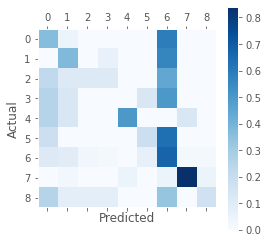



LogisticRegression
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.00      0.00      0.00        16
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         8
           5       0.00      0.00      0.00        11
           6       0.47      0.99      0.64        76
           7       0.83      0.89      0.86        44
           8       0.00      0.00      0.00        12

    accuracy                           0.55       206
   macro avg       0.14      0.21      0.17       206
weighted avg       0.35      0.55      0.42       206

accuracy:  0.5533980582524272
Per class accuracy:  0.20813397129186603
Exact match accuracy:  0.5533980582524272


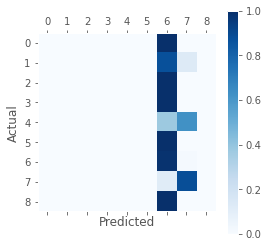



Decision Tree
              precision    recall  f1-score   support

           0       0.61      0.77      0.68        22
           1       0.33      0.44      0.38        16
           2       0.40      0.44      0.42         9
           3       0.00      0.00      0.00         8
           4       0.60      0.38      0.46         8
           5       0.27      0.36      0.31        11
           6       0.74      0.67      0.70        76
           7       0.93      0.93      0.93        44
           8       0.50      0.33      0.40        12

    accuracy                           0.64       206
   macro avg       0.49      0.48      0.48       206
weighted avg       0.65      0.64      0.64       206

accuracy:  0.6359223300970874
Per class accuracy:  0.4810569141709492
Exact match accuracy:  0.6359223300970874


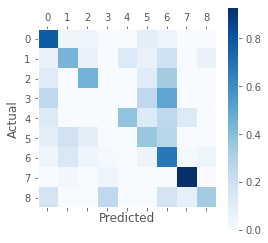



Neural Net
              precision    recall  f1-score   support

           0       0.40      0.18      0.25        22
           1       0.25      0.06      0.10        16
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00         8
           4       0.03      0.12      0.05         8
           5       0.00      0.00      0.00        11
           6       0.49      0.51      0.50        76
           7       0.53      0.95      0.68        44
           8       0.00      0.00      0.00        12

    accuracy                           0.42       206
   macro avg       0.19      0.20      0.18       206
weighted avg       0.36      0.42      0.37       206

accuracy:  0.4223300970873786
Per class accuracy:  0.20411350345560872
Exact match accuracy:  0.4223300970873786


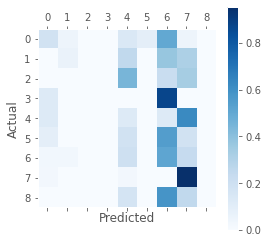



Random Forest
              precision    recall  f1-score   support

           0       0.62      0.91      0.74        22
           1       0.67      0.50      0.57        16
           2       0.60      0.33      0.43         9
           3       0.33      0.12      0.18         8
           4       1.00      0.50      0.67         8
           5       0.43      0.27      0.33        11
           6       0.69      0.87      0.77        76
           7       0.95      0.95      0.95        44
           8       0.75      0.25      0.38        12

    accuracy                           0.73       206
   macro avg       0.67      0.52      0.56       206
weighted avg       0.72      0.73      0.70       206

accuracy:  0.7281553398058253
Per class accuracy:  0.5236797802587276
Exact match accuracy:  0.7281553398058253


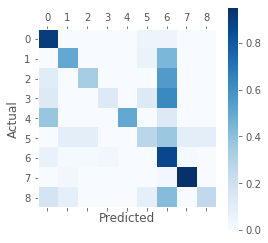



Gradient Boost
              precision    recall  f1-score   support

           0       0.75      0.82      0.78        22
           1       0.40      0.38      0.39        16
           2       0.60      0.33      0.43         9
           3       0.50      0.25      0.33         8
           4       0.80      0.50      0.62         8
           5       0.40      0.18      0.25        11
           6       0.69      0.89      0.78        76
           7       0.98      0.95      0.97        44
           8       0.83      0.42      0.56        12

    accuracy                           0.73       206
   macro avg       0.66      0.52      0.57       206
weighted avg       0.72      0.73      0.71       206

accuracy:  0.7281553398058253
Per class accuracy:  0.5249202551834131
Exact match accuracy:  0.7281553398058253


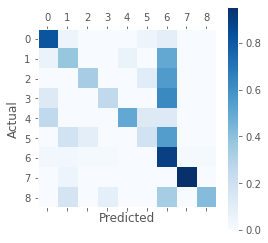



[14:50:22] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XG-Boost
              precision    recall  f1-score   support

           0       0.74      0.77      0.76        22
           1       0.33      0.38      0.35        16
           2       0.60      0.33      0.43         9
           3       0.40      0.25      0.31         8
           4       0.80      0.50      0.62         8
           5       0.30      0.27      0.29        11
           6       0.70      0.82      0.76        76
           7       0.98      0.95      0.97        44
           8       0.56      0.42      0.48        12

    accuracy                           0.70       206
   macro avg       0.60      0.52      0.55       206
weighted avg       0.69      0.70      0.69      

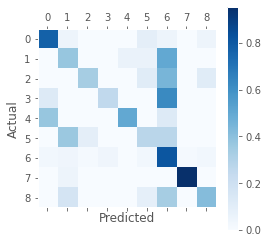

In [51]:
# K-nearest neighbors, Logistic regression, Decision trees, Random forest, Gradient boosting machine
model_names = ['KNN', 'LR', 'DT', 'MLP', 'RF', 'GBM']
data_acc = []
data_f1 = []

# KNN
KNN = KNeighborsClassifier()
KNN.fit(x_train, y_train)
y_pred = KNN.predict(x_val)
print('K-Nearest Neighbors')
print(classification_report(y_val, y_pred))
print('accuracy: ', accuracy_score(y_val, y_pred))
conf_mx = confusion_matrix(y_val, y_pred)
print('Per class accuracy: ',np.mean(conf_mx.diagonal()/conf_mx.sum(axis=1)))
print('Exact match accuracy: ',accuracy_score(y_val,y_pred))
conf_mx = conf_mx / conf_mx.astype(np.float).sum(axis=1)[:,None]
plt.matshow(conf_mx, cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.grid(False)
plt.show()
print('\n')

LR = LogisticRegression()
LR.fit(x_train, y_train)
y_pred = LR.predict(x_val)
print('LogisticRegression')
print(classification_report(y_val, y_pred))
print('accuracy: ', accuracy_score(y_val, y_pred))
conf_mx = confusion_matrix(y_val, y_pred)
print('Per class accuracy: ',np.mean(conf_mx.diagonal()/conf_mx.sum(axis=1)))
print('Exact match accuracy: ',accuracy_score(y_val,y_pred))
conf_mx = conf_mx / conf_mx.astype(np.float).sum(axis=1)[:,None]
plt.matshow(conf_mx, cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.grid(False)
plt.show()
print('\n')

DT = DecisionTreeClassifier()
DT.fit(x_train, y_train)
y_pred = DT.predict(x_val)
print('Decision Tree')
print(classification_report(y_val, y_pred))
print('accuracy: ', accuracy_score(y_val, y_pred))
conf_mx = confusion_matrix(y_val, y_pred)
print('Per class accuracy: ',np.mean(conf_mx.diagonal()/conf_mx.sum(axis=1)))
print('Exact match accuracy: ',accuracy_score(y_val,y_pred))
conf_mx = conf_mx / conf_mx.astype(np.float).sum(axis=1)[:,None]
plt.matshow(conf_mx, cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.grid(False)
plt.show()
print('\n')

MLP = MLPClassifier()
MLP.fit(x_train, y_train)
y_pred = MLP.predict(x_val)
print('Neural Net')
print(classification_report(y_val, y_pred))
print('accuracy: ', accuracy_score(y_val, y_pred))
conf_mx = confusion_matrix(y_val, y_pred)
print('Per class accuracy: ',np.mean(conf_mx.diagonal()/conf_mx.sum(axis=1)))
print('Exact match accuracy: ',accuracy_score(y_val,y_pred))
conf_mx = conf_mx / conf_mx.astype(np.float).sum(axis=1)[:,None]
plt.matshow(conf_mx, cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.grid(False)
plt.show()
print('\n')

RF = RandomForestClassifier()
RF.fit(x_train, y_train)
y_pred = RF.predict(x_val)
print('Random Forest')
print(classification_report(y_val, y_pred))
print('accuracy: ', accuracy_score(y_val, y_pred))
conf_mx = confusion_matrix(y_val, y_pred)
print('Per class accuracy: ',np.mean(conf_mx.diagonal()/conf_mx.sum(axis=1)))
print('Exact match accuracy: ',accuracy_score(y_val,y_pred))
conf_mx = conf_mx / conf_mx.astype(np.float).sum(axis=1)[:,None]
plt.matshow(conf_mx, cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.grid(False)
plt.show()
print('\n')

GBM = GradientBoostingClassifier()
GBM.fit(x_train, y_train)
y_pred = GBM.predict(x_val)
print('Gradient Boost')
print(classification_report(y_val, y_pred))
print('accuracy: ', accuracy_score(y_val, y_pred))
conf_mx = confusion_matrix(y_val, y_pred)
print('Per class accuracy: ',np.mean(conf_mx.diagonal()/conf_mx.sum(axis=1)))
print('Exact match accuracy: ',accuracy_score(y_val,y_pred))
conf_mx = conf_mx / conf_mx.astype(np.float).sum(axis=1)[:,None]
plt.matshow(conf_mx, cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.grid(False)
plt.show()
print('\n')

XGB = xgb.XGBClassifier()
XGB.fit(x_train,y_train)
y_pred = XGB.predict(x_val)
print('XG-Boost')
print(classification_report(y_val, y_pred))
print('accuracy: ', accuracy_score(y_val, y_pred))
conf_mx = confusion_matrix(y_val, y_pred)
print('Per class accuracy: ',np.mean(conf_mx.diagonal()/conf_mx.sum(axis=1)))
print('Exact match accuracy: ',accuracy_score(y_val,y_pred))
conf_mx = conf_mx / conf_mx.astype(np.float).sum(axis=1)[:,None]
plt.matshow(conf_mx, cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.grid(False)
plt.show()
print('\n')


### Model Tuning
- The 3 tree based ensemble models perform similarly
- Hyperparameter tuning is applied to random forest classifier with 5 fold cross validation
    - Random grid search with larger range of hyperparameter values to narrow down range 
    - Exhaustive grid search with smaller range of hyperparamter values to identify best model

In [52]:
x_train_final = x_train_final[['Rated Power (kW)','Duration (hours)','Elevation Difference', 'Max Temp', 'Min Temp', 'Average Temp']]
x_test_final = x_test_final[['Rated Power (kW)','Duration (hours)','Elevation Difference', 'Max Temp', 'Min Temp', 'Average Temp']]

In [53]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 50)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [54]:
RF = RandomForestClassifier()
RF_grid = RandomizedSearchCV(estimator = RF, param_distributions = random_grid, n_iter = 50, cv = 5, verbose=2, random_state=42, n_jobs = -1)

RF_grid.fit(x_train_final, y_train_final)
best_params = RF_grid.best_params_
print(best_params)
print(RF_grid.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'n_estimators': 230, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True}
0.7007624911200568


In [55]:
# build new search grid around the best solution found in random search
n_estimators_b = best_params['n_estimators']
max_depth_b = best_params['max_depth']
min_samples_split_b = best_params['min_samples_split']
min_samples_leaf_b = best_params['min_samples_leaf']

# Number of trees in random forest
n_estimators = [n_estimators_b-10, n_estimators_b, n_estimators_b+10]
# Maximum number of levels in tree
max_depth = [max_depth_b-5, max_depth_b, max_depth_b+5]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [min_samples_split_b-1, min_samples_split_b, min_samples_split_b+1]
# Minimum number of samples required at each leaf node
min_samples_leaf = [min_samples_leaf_b-1, min_samples_leaf_b, min_samples_leaf_b+1]

params = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [56]:
# perform exhaustive grid search
RF = RandomForestClassifier()

RF_grid = GridSearchCV(estimator = RF, param_grid = params, scoring = 'accuracy', cv = 5, verbose=3, n_jobs = -1)

RF_grid.fit(x_train_final, y_train_final)
best_params = RF_grid.best_params_

RF = RandomForestClassifier(n_estimators = best_params["n_estimators"],
                            max_depth = best_params["max_depth"],
                            min_samples_split = best_params["min_samples_split"],
                            min_samples_leaf = best_params["min_samples_leaf"],
                            bootstrap = False,)
RF.fit(x_train_final, y_train_final)
y_pred = RF.predict(x_test_final)

print(classification_report(y_test_final, y_pred))
print('accuracy: ', accuracy_score(y_test_final, y_pred))
print('\n')

Fitting 5 folds for each of 108 candidates, totalling 540 fits
              precision    recall  f1-score   support

           0       0.71      0.83      0.76        41
           1       0.37      0.23      0.29        30
           2       0.20      0.29      0.24         7
           3       1.00      0.15      0.26        20
           4       0.92      0.65      0.76        17
           5       0.50      0.25      0.33        20
           6       0.66      0.88      0.75       110
           7       0.95      0.99      0.97        82
           8       0.57      0.27      0.36        15

    accuracy                           0.71       342
   macro avg       0.65      0.50      0.52       342
weighted avg       0.72      0.71      0.68       342

accuracy:  0.7134502923976608




Accuracy of the RF on test set: 0.713


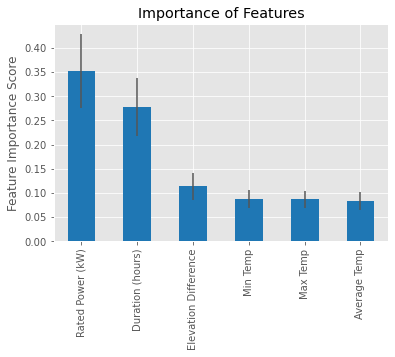

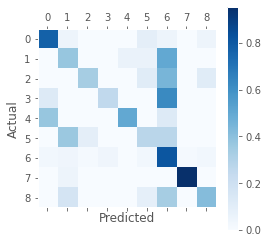

<Figure size 432x288 with 0 Axes>

In [59]:
predictors=list(x_train_final)

feat_imp = pd.Series(RF.feature_importances_, predictors).sort_values(ascending=False)
importances = RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in RF.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

feat_imp.plot(kind='bar', title='Importance of Features',color='tab:blue',yerr=std[indices], align="center")
plt.ylabel('Feature Importance Score')
print('Accuracy of the RF on test set: {:.3f}'.format(RF.score(x_test_final, y_test_final)))
conf_mx = conf_mx / conf_mx.astype(np.float).sum(axis=1)[:,None]
plt.matshow(conf_mx, cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.grid(False)
plt.show()
print('\n')
plt.savefig('Feature importance.svg',bbox_inches='tight')

In [60]:
tech_cat_mapping=dict(zip(tech_cat,tech_cat_encoded))
print(tech_cat_mapping)
best_params

{'Pumped Hydro Storage': 7, 'Electro-mechanical': 2, 'Cold Thermal': 0, 'Lead Battery': 5, 'Flow Battery': 3, 'Sodium Battery': 8, 'Electro-chemical': 1, 'Hot Thermal': 4, 'Lithium Battery': 6}


{'max_depth': 100,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 230}

## Tunning Gradient Boosting

In [61]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 50)]
# Number of features to consider at every split
#max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(start = 3, stop = 100, num = 10)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 7]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
#bootstrap = [True, False]# Create the random grid

learning_rate=[x for x in np.linspace(start = 0.05, stop = 0.15, num = 3)]
subsample=[0.75,0.9,1]
max_features=[3,4,5,6,7]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'learning_rate':learning_rate,
               'subsample':subsample}

print(random_grid)

GB = GradientBoostingClassifier()
GB_random = RandomizedSearchCV(estimator = GB, param_distributions = random_grid, n_iter = 50, cv = 5, verbose=3, random_state=42, n_jobs = 1)
GB_random.fit(x_train_final, y_train_final)
best_params = GB_random.best_params_

print(best_params)
print(RF_grid.best_score_)

{'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500], 'max_features': [3, 4, 5, 6, 7], 'max_depth': [3, 13, 24, 35, 46, 56, 67, 78, 89, 100], 'min_samples_split': [2, 5, 7], 'min_samples_leaf': [1, 2, 4], 'learning_rate': [0.05, 0.1, 0.15], 'subsample': [0.75, 0.9, 1]}
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END learning_rate=0.1, max_depth=89, max_features=3, min_samples_leaf=2, min_samples_split=2, n_estimators=30, subsample=1; total time=   8.1s
[CV 2/5] END learning_rate=0.1, max_depth=89, max_features=3, min_samples_leaf=2, min_samples_split=2, n_estimators=30, subsample=1; total time=   7.8s
[CV 3/5] END learning_rate=0.1, max_depth=89, max_features=3, min_samples_leaf=2, min_samples_split=2, n_estimators=30, subsample=1; total time=   8.0s
[CV 4/

[CV 1/5] END learning_rate=0.1, max_depth=67, max_features=6, min_samples_leaf=2, min_samples_split=5, n_estimators=260, subsample=1; total time= 1.3min
[CV 2/5] END learning_rate=0.1, max_depth=67, max_features=6, min_samples_leaf=2, min_samples_split=5, n_estimators=260, subsample=1; total time= 1.4min
[CV 3/5] END learning_rate=0.1, max_depth=67, max_features=6, min_samples_leaf=2, min_samples_split=5, n_estimators=260, subsample=1; total time= 1.4min
[CV 4/5] END learning_rate=0.1, max_depth=67, max_features=6, min_samples_leaf=2, min_samples_split=5, n_estimators=260, subsample=1; total time= 1.5min
[CV 5/5] END learning_rate=0.1, max_depth=67, max_features=6, min_samples_leaf=2, min_samples_split=5, n_estimators=260, subsample=1; total time= 1.3min
[CV 1/5] END learning_rate=0.1, max_depth=89, max_features=6, min_samples_leaf=2, min_samples_split=7, n_estimators=90, subsample=0.75; total time=  20.8s
[CV 2/5] END learning_rate=0.1, max_depth=89, max_features=6, min_samples_leaf=2

[CV 4/5] END learning_rate=0.15, max_depth=89, max_features=6, min_samples_leaf=4, min_samples_split=2, n_estimators=260, subsample=1; total time=  18.1s
[CV 5/5] END learning_rate=0.15, max_depth=89, max_features=6, min_samples_leaf=4, min_samples_split=2, n_estimators=260, subsample=1; total time=  18.8s
[CV 1/5] END learning_rate=0.05, max_depth=100, max_features=6, min_samples_leaf=1, min_samples_split=2, n_estimators=420, subsample=1; total time=  42.8s
[CV 2/5] END learning_rate=0.05, max_depth=100, max_features=6, min_samples_leaf=1, min_samples_split=2, n_estimators=420, subsample=1; total time=  39.4s
[CV 3/5] END learning_rate=0.05, max_depth=100, max_features=6, min_samples_leaf=1, min_samples_split=2, n_estimators=420, subsample=1; total time=  41.8s
[CV 4/5] END learning_rate=0.05, max_depth=100, max_features=6, min_samples_leaf=1, min_samples_split=2, n_estimators=420, subsample=1; total time=  47.5s
[CV 5/5] END learning_rate=0.05, max_depth=100, max_features=6, min_samp

[CV 2/5] END learning_rate=0.1, max_depth=89, max_features=3, min_samples_leaf=4, min_samples_split=2, n_estimators=460, subsample=1; total time=  23.2s
[CV 3/5] END learning_rate=0.1, max_depth=89, max_features=3, min_samples_leaf=4, min_samples_split=2, n_estimators=460, subsample=1; total time=  22.9s
[CV 4/5] END learning_rate=0.1, max_depth=89, max_features=3, min_samples_leaf=4, min_samples_split=2, n_estimators=460, subsample=1; total time=  20.1s
[CV 5/5] END learning_rate=0.1, max_depth=89, max_features=3, min_samples_leaf=4, min_samples_split=2, n_estimators=460, subsample=1; total time=  21.7s
[CV 1/5] END learning_rate=0.15, max_depth=24, max_features=3, min_samples_leaf=4, min_samples_split=2, n_estimators=350, subsample=0.9; total time=  15.6s
[CV 2/5] END learning_rate=0.15, max_depth=24, max_features=3, min_samples_leaf=4, min_samples_split=2, n_estimators=350, subsample=0.9; total time=  16.2s
[CV 3/5] END learning_rate=0.15, max_depth=24, max_features=3, min_samples_l

[CV 5/5] END learning_rate=0.1, max_depth=78, max_features=6, min_samples_leaf=2, min_samples_split=2, n_estimators=330, subsample=0.75; total time=  25.1s
[CV 1/5] END learning_rate=0.05, max_depth=100, max_features=7, min_samples_leaf=4, min_samples_split=7, n_estimators=290, subsample=0.9; total time=   0.0s
[CV 2/5] END learning_rate=0.05, max_depth=100, max_features=7, min_samples_leaf=4, min_samples_split=7, n_estimators=290, subsample=0.9; total time=   0.0s
[CV 3/5] END learning_rate=0.05, max_depth=100, max_features=7, min_samples_leaf=4, min_samples_split=7, n_estimators=290, subsample=0.9; total time=   0.0s
[CV 4/5] END learning_rate=0.05, max_depth=100, max_features=7, min_samples_leaf=4, min_samples_split=7, n_estimators=290, subsample=0.9; total time=   0.0s
[CV 5/5] END learning_rate=0.05, max_depth=100, max_features=7, min_samples_leaf=4, min_samples_split=7, n_estimators=290, subsample=0.9; total time=   0.0s
[CV 1/5] END learning_rate=0.05, max_depth=89, max_features

In [63]:
# build new search grid around the best solution found in random search
n_estimators_b = best_params['n_estimators']
max_depth_b = best_params['max_depth']
min_samples_split_b = best_params['min_samples_split']
min_samples_leaf_b = best_params['min_samples_leaf']
learning_rate_b = best_params['learning_rate']
subsample_b = best_params['subsample']
max_features_b = best_params['max_features']

n_estimators = [n_estimators_b-10, n_estimators_b, n_estimators_b+10]
max_depth = [max_depth_b-1, max_depth_b, max_depth_b+1]
min_samples_split = [min_samples_split_b-1, min_samples_split_b, min_samples_split_b+1]
min_samples_leaf = [min_samples_leaf_b-1, min_samples_leaf_b, min_samples_leaf_b+1]
learning_rate = [learning_rate_b]
subsample =[subsample_b]
max_features = [max_features_b]

params = {'n_estimators': n_estimators,
          'max_depth': max_depth,
          'min_samples_split': min_samples_split,
          'min_samples_leaf': min_samples_leaf,
          'learning_rate': learning_rate,
          'subsample': subsample,
          'max_features': max_features}

In [64]:
GB = GradientBoostingClassifier()

GB_grid = GridSearchCV(estimator = GB, param_grid = params, scoring = 'accuracy', cv = 5, verbose=2, n_jobs = 1)

GB_grid.fit(x_train_final, y_train_final)
best_params = GB_grid.best_params_

GB = GradientBoostingClassifier(n_estimators = best_params["n_estimators"],
                                max_depth = best_params["max_depth"],
                                min_samples_split = best_params["min_samples_split"],
                                min_samples_leaf = best_params["min_samples_leaf"],
                                learning_rate=best_params['learning_rate'],
                                subsample=best_params['subsample'],
                                max_features=best_params['max_features'])

GB.fit(x_train_final, y_train_final)
y_pred = GB.predict(x_test_final)

print(classification_report(y_test_final, y_pred))
print('accuracy: ', accuracy_score(y_test_final, y_pred))
print('\n')

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END learning_rate=0.05, max_depth=2, max_features=3, min_samples_leaf=1, min_samples_split=6, n_estimators=60, subsample=0.9; total time=   0.3s
[CV] END learning_rate=0.05, max_depth=2, max_features=3, min_samples_leaf=1, min_samples_split=6, n_estimators=60, subsample=0.9; total time=   0.3s
[CV] END learning_rate=0.05, max_depth=2, max_features=3, min_samples_leaf=1, min_samples_split=6, n_estimators=60, subsample=0.9; total time=   0.3s
[CV] END learning_rate=0.05, max_depth=2, max_features=3, min_samples_leaf=1, min_samples_split=6, n_estimators=60, subsample=0.9; total time=   0.3s
[CV] END learning_rate=0.05, max_depth=2, max_features=3, min_samples_leaf=1, min_samples_split=6, n_estimators=60, subsample=0.9; total time=   0.3s
[CV] END learning_rate=0.05, max_depth=2, max_features=3, min_samples_leaf=1, min_samples_split=6, n_estimators=70, subsample=0.9; total time=   0.4s
[CV] END learning_rate=0.05, max_depth

[CV] END learning_rate=0.05, max_depth=2, max_features=3, min_samples_leaf=2, min_samples_split=6, n_estimators=80, subsample=0.9; total time=   0.4s
[CV] END learning_rate=0.05, max_depth=2, max_features=3, min_samples_leaf=2, min_samples_split=6, n_estimators=80, subsample=0.9; total time=   0.5s
[CV] END learning_rate=0.05, max_depth=2, max_features=3, min_samples_leaf=2, min_samples_split=6, n_estimators=80, subsample=0.9; total time=   0.4s
[CV] END learning_rate=0.05, max_depth=2, max_features=3, min_samples_leaf=2, min_samples_split=6, n_estimators=80, subsample=0.9; total time=   0.4s
[CV] END learning_rate=0.05, max_depth=2, max_features=3, min_samples_leaf=2, min_samples_split=6, n_estimators=80, subsample=0.9; total time=   0.5s
[CV] END learning_rate=0.05, max_depth=2, max_features=3, min_samples_leaf=2, min_samples_split=7, n_estimators=60, subsample=0.9; total time=   0.3s
[CV] END learning_rate=0.05, max_depth=2, max_features=3, min_samples_leaf=2, min_samples_split=7, n

[CV] END learning_rate=0.05, max_depth=2, max_features=3, min_samples_leaf=3, min_samples_split=7, n_estimators=70, subsample=0.9; total time=   0.4s
[CV] END learning_rate=0.05, max_depth=2, max_features=3, min_samples_leaf=3, min_samples_split=7, n_estimators=70, subsample=0.9; total time=   0.4s
[CV] END learning_rate=0.05, max_depth=2, max_features=3, min_samples_leaf=3, min_samples_split=7, n_estimators=70, subsample=0.9; total time=   0.4s
[CV] END learning_rate=0.05, max_depth=2, max_features=3, min_samples_leaf=3, min_samples_split=7, n_estimators=70, subsample=0.9; total time=   0.4s
[CV] END learning_rate=0.05, max_depth=2, max_features=3, min_samples_leaf=3, min_samples_split=7, n_estimators=70, subsample=0.9; total time=   0.4s
[CV] END learning_rate=0.05, max_depth=2, max_features=3, min_samples_leaf=3, min_samples_split=7, n_estimators=80, subsample=0.9; total time=   0.5s
[CV] END learning_rate=0.05, max_depth=2, max_features=3, min_samples_leaf=3, min_samples_split=7, n

[CV] END learning_rate=0.05, max_depth=3, max_features=3, min_samples_leaf=1, min_samples_split=8, n_estimators=60, subsample=0.9; total time=   0.4s
[CV] END learning_rate=0.05, max_depth=3, max_features=3, min_samples_leaf=1, min_samples_split=8, n_estimators=60, subsample=0.9; total time=   0.4s
[CV] END learning_rate=0.05, max_depth=3, max_features=3, min_samples_leaf=1, min_samples_split=8, n_estimators=60, subsample=0.9; total time=   0.4s
[CV] END learning_rate=0.05, max_depth=3, max_features=3, min_samples_leaf=1, min_samples_split=8, n_estimators=60, subsample=0.9; total time=   0.4s
[CV] END learning_rate=0.05, max_depth=3, max_features=3, min_samples_leaf=1, min_samples_split=8, n_estimators=60, subsample=0.9; total time=   0.4s
[CV] END learning_rate=0.05, max_depth=3, max_features=3, min_samples_leaf=1, min_samples_split=8, n_estimators=70, subsample=0.9; total time=   0.5s
[CV] END learning_rate=0.05, max_depth=3, max_features=3, min_samples_leaf=1, min_samples_split=8, n

[CV] END learning_rate=0.05, max_depth=3, max_features=3, min_samples_leaf=2, min_samples_split=8, n_estimators=80, subsample=0.9; total time=   0.5s
[CV] END learning_rate=0.05, max_depth=3, max_features=3, min_samples_leaf=2, min_samples_split=8, n_estimators=80, subsample=0.9; total time=   0.6s
[CV] END learning_rate=0.05, max_depth=3, max_features=3, min_samples_leaf=2, min_samples_split=8, n_estimators=80, subsample=0.9; total time=   0.5s
[CV] END learning_rate=0.05, max_depth=3, max_features=3, min_samples_leaf=2, min_samples_split=8, n_estimators=80, subsample=0.9; total time=   0.6s
[CV] END learning_rate=0.05, max_depth=3, max_features=3, min_samples_leaf=2, min_samples_split=8, n_estimators=80, subsample=0.9; total time=   0.5s
[CV] END learning_rate=0.05, max_depth=3, max_features=3, min_samples_leaf=3, min_samples_split=6, n_estimators=60, subsample=0.9; total time=   0.3s
[CV] END learning_rate=0.05, max_depth=3, max_features=3, min_samples_leaf=3, min_samples_split=6, n

[CV] END learning_rate=0.05, max_depth=4, max_features=3, min_samples_leaf=1, min_samples_split=6, n_estimators=70, subsample=0.9; total time=   0.9s
[CV] END learning_rate=0.05, max_depth=4, max_features=3, min_samples_leaf=1, min_samples_split=6, n_estimators=70, subsample=0.9; total time=   0.9s
[CV] END learning_rate=0.05, max_depth=4, max_features=3, min_samples_leaf=1, min_samples_split=6, n_estimators=70, subsample=0.9; total time=   0.8s
[CV] END learning_rate=0.05, max_depth=4, max_features=3, min_samples_leaf=1, min_samples_split=6, n_estimators=70, subsample=0.9; total time=   0.8s
[CV] END learning_rate=0.05, max_depth=4, max_features=3, min_samples_leaf=1, min_samples_split=6, n_estimators=70, subsample=0.9; total time=   0.9s
[CV] END learning_rate=0.05, max_depth=4, max_features=3, min_samples_leaf=1, min_samples_split=6, n_estimators=80, subsample=0.9; total time=   1.2s
[CV] END learning_rate=0.05, max_depth=4, max_features=3, min_samples_leaf=1, min_samples_split=6, n

[CV] END learning_rate=0.05, max_depth=4, max_features=3, min_samples_leaf=2, min_samples_split=7, n_estimators=60, subsample=0.9; total time=   0.6s
[CV] END learning_rate=0.05, max_depth=4, max_features=3, min_samples_leaf=2, min_samples_split=7, n_estimators=60, subsample=0.9; total time=   0.6s
[CV] END learning_rate=0.05, max_depth=4, max_features=3, min_samples_leaf=2, min_samples_split=7, n_estimators=60, subsample=0.9; total time=   0.6s
[CV] END learning_rate=0.05, max_depth=4, max_features=3, min_samples_leaf=2, min_samples_split=7, n_estimators=60, subsample=0.9; total time=   0.5s
[CV] END learning_rate=0.05, max_depth=4, max_features=3, min_samples_leaf=2, min_samples_split=7, n_estimators=60, subsample=0.9; total time=   0.6s
[CV] END learning_rate=0.05, max_depth=4, max_features=3, min_samples_leaf=2, min_samples_split=7, n_estimators=70, subsample=0.9; total time=   0.8s
[CV] END learning_rate=0.05, max_depth=4, max_features=3, min_samples_leaf=2, min_samples_split=7, n

[CV] END learning_rate=0.05, max_depth=4, max_features=3, min_samples_leaf=3, min_samples_split=7, n_estimators=80, subsample=0.9; total time=   0.7s
[CV] END learning_rate=0.05, max_depth=4, max_features=3, min_samples_leaf=3, min_samples_split=7, n_estimators=80, subsample=0.9; total time=   0.8s
[CV] END learning_rate=0.05, max_depth=4, max_features=3, min_samples_leaf=3, min_samples_split=7, n_estimators=80, subsample=0.9; total time=   0.8s
[CV] END learning_rate=0.05, max_depth=4, max_features=3, min_samples_leaf=3, min_samples_split=7, n_estimators=80, subsample=0.9; total time=   1.0s
[CV] END learning_rate=0.05, max_depth=4, max_features=3, min_samples_leaf=3, min_samples_split=7, n_estimators=80, subsample=0.9; total time=   1.0s
[CV] END learning_rate=0.05, max_depth=4, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=60, subsample=0.9; total time=   0.7s
[CV] END learning_rate=0.05, max_depth=4, max_features=3, min_samples_leaf=3, min_samples_split=8, n

In [69]:
dump(RF, 'Model.joblib') 

['Model.joblib']